In [11]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

sns.set_theme(font="Arial", style="white", context="poster")

In [12]:

def preprocess_design_matrix(design_matrix):

    design_matrix = design_matrix[
        (design_matrix['Sepsis Prob'] >= 0.8)
        #(design_matrix['Sepsis Prob'] > 0.50))
    ].copy()

    design_matrix['group'] = np.where(
        design_matrix['sepsis_or_septic_shock'] == 1, 2, 1
    )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [13]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]


    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix.annotate()     


In [14]:
def preprocess_test_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix.annotate()   

# Model Training

In [15]:
ms_data = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)

In [16]:
design_matrix_otrain = pd.read_csv(
    "../1_clinical_digital_family/design_matrix_test_sepsis_risk.tsv",
    sep='\t'
)

In [17]:
design_matrix_otrain['Sepsis Prob'].value_counts()

Sepsis Prob
1.000    15
0.908     8
0.639     5
0.999     4
0.550     3
         ..
0.881     1
0.879     1
0.496     1
0.640     1
0.899     1
Name: count, Length: 561, dtype: int64

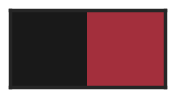

In [18]:
custom_palette = ["k", "#A32F3C"]  # Define hex colors
palette = sns.color_palette(custom_palette, as_cmap=True)
sns.palplot(custom_palette)

In [19]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

<Axes: xlabel='Sepsis Prob', ylabel='Count'>

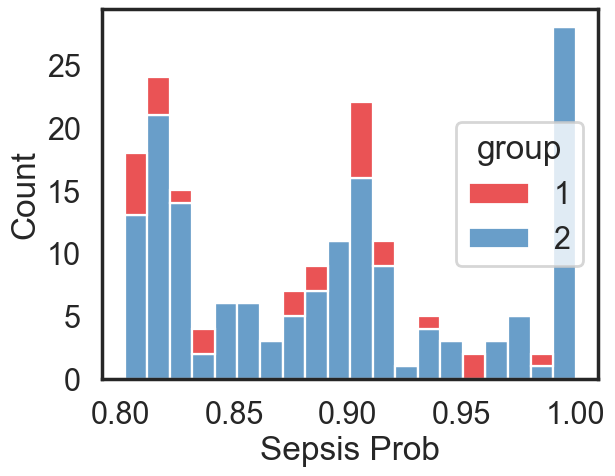

In [20]:
sns.histplot(
    design_matrix_train,
    x="Sepsis Prob",
    hue="group",
    palette="Set1",
    multiple="stack",
    bins=20
)

In [21]:
design_matrix_train['group'].value_counts()

group
2    158
1     27
Name: count, dtype: int64

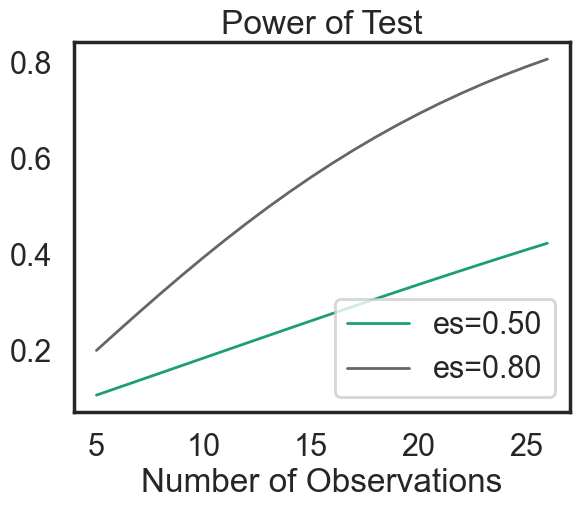

In [22]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train['group'].value_counts()[1]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [23]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [24]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [25]:
#quant_matrix_train.write("highrisk_sepsis_de_proteins.tsv")

In [26]:
quant_matrix_de = quant_matrix_train.to_df()

In [27]:
quant_matrix_de['Color'] = np.where(
    quant_matrix_de['CorrectedPValue2-1'] <= 0.01, 1, 0
)

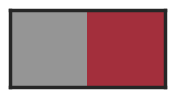

In [28]:
custom_palette = ["#959595", "#A32F3C"]  # Define hex colors
palette = sns.color_palette(custom_palette, as_cmap=True)
sns.palplot(custom_palette)

In [29]:
quant_matrix_de[quant_matrix_de['CorrectedPValue2-1'] <= 0.05]

,Protein,ProteinLabel,Gene,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,...,SA_BOX_1-1187_S1-A9_1_6854,SA_BOX_13-2036_S1-G11_1_6583,SA_BOX_15-663_S4-C1_1_6694,SA_BOX_1-259_S1-G5_1_6827,SA_BOX_14-1566_S2-H4_1_6625,SA_BOX_8-1160_S5-E3_1_6025,SA_BOX_12-1949_S5-C4_1_6424,SA_BOX_6-659_S2-F10_1_5887,SA_BOX_2-764_S2-G2_1_6901,Color


/tmp/ipykernel_1111338/1986360940.py:1: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  ax = sns.scatterplot(


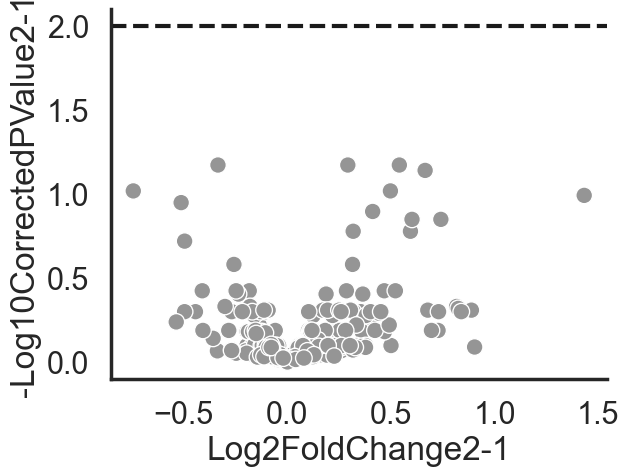

In [30]:
ax = sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1",
    hue="Color",
    #s=30,
    #alpha=0.8,
    legend=False,
    palette=palette
)

ax.axhline(
    -np.log10(0.01), c="k", linestyle="--"
)
sns.despine()
#ax.figure.set_size_inches((3, 3))

In [31]:
ax.figure.savefig(
    "sepsis_volcano_sepsis_to_non_sepsis_in_high_group.pdf", dpi=300, bbox_inches="tight"
)